# Summarization with blurr
> blurr is a libray I started that integrates huggingface transformers with the world of fastai v2, giving fastai devs everything they need to train, evaluate, and deploy transformer specific models.  In this article, I provide a simple example of how to use blurr's new summarization capabilities to train, evaluate, and deploy a BART summarization model.

*Updated on 08/20/2020 to use fastai2 0.0.30 and also demo batch-time padding*

- toc: false 
- badges: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, huggingface, blurr, summarization, text generation]
- image: images/articles/blurr-logo-small.png
- hide: false
- search_exclude: false
- show_tags: true

In [25]:
# only run this cell if you are in collab
# !pip install ohmeow-blurr
# !pip install nlp

In [2]:
import nlp
import pandas as pd
from fastai2.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

## Data Preparation

We're going to use to use the new [nlp](https://github.com/huggingface/nlp) library from huggingface to grab your raw data.  This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model.  The best part being everything comes down to you in JSON!  This makes it a breeze to get up and running quickly!

In [3]:
raw_data = nlp.load_dataset('cnn_dailymail', '3.0.0')
raw_data.keys()

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/d8c27f2d603e2864036d92b0ec379f081896f6c28605ffd2e194c42cd04d48d8. Subsequent calls will reuse this data.


dict_keys(['train', 'validation', 'test'])

We'll just use a subset of the training set to build both our training and validation DataLoaders

In [4]:
df = pd.DataFrame(raw_data['train'])
df.head()

,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years. Under the program, ...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting program, like all GSA practices, is under review .",00027e965c8264c35cc1bc55556db388da82b07f
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. ""I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case,"" Stancheva told CNN in a phone intervie...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .",0002c17436637c4fe1837c935c04de47adb18e9a
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police L

We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model).  We'll use blurr's `get_hf_objects` helper method here.

In [5]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('bart',
 transformers.configuration_bart.BartConfig,
 transformers.tokenization_bart.BartTokenizer,
 transformers.modeling_bart.BartForConditionalGeneration)

Next we need to build out our DataBlock.  Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice we're specifying `max_length` to constrain our decoder inputs to 150 so that our input/predicted summaries will be padded to 150 rather than the default which is whatever you are using for your encoder inputs (e.g., the text you want summarized).

In [10]:
hf_batch_tfm = HF_SummarizationBatchTransform(hf_arch, hf_tokenizer)

blocks = ( 
    HF_TextBlock(hf_arch, hf_tokenizer), 
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm, max_length=150, hf_input_idxs=[0,1])
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSubsetSplitter(0.01, 0.0005))

In [11]:
dls = dblock.dataloaders(df, bs=2)

In [12]:
len(dls.train.items), len(dls.valid.items)

(2871, 143)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [13]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 512]), torch.Size([2, 110]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.

In [14]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,target
0,"They hired some of the most famous women in the country and a celebrity photographer to showcase their latest collection – forking out £5million for the privilege. But Marks & Spencer’s make-or-break advertising campaign has failed to deliver a much-needed boost to sales. M&S yesterday revealed that its sales of fashion and general merchandise have fallen, a trend that has hampered the firm for more than two years. Meanwhile, budget brand Primark is faring much better announcing record profits of £154million last year. Flop? The leading ladies show off the M&S collection, but but clothing and general merchandise sales are down yet again. Mixed fortunes: Primark has today announced record profits as struggling rival Marks & Spencer revealed its ninth consecutive quarter of falling clothing sales and a drop in profits. Christmas hope: This week M&S launches its Christmas 'Believe in Magic and Sparkle' advertisement which has a glossy Alice in Wonderland theme and stars Rosie Huntington-Whiteley. The store's total sales rose by 22 per cent, while its like-for-like figures were also up five per cent in the year to 14 September, pushing up their profits 44 per cent. Unlike M&S, it relied on a reputation for low prices rather than expensive marketing campaigns to drive sales. M&S. figures come despite its ‘Leading Ladies’ initiative, starring the. likes of Dame Helen Mirren and Tracey Emin and photographed by Annie. Leibovitz, which was meant to propel the firm in a new direction. The. chain faces a make-or-break Christmas to turn round its fortunes as as. its first-half pre-tax profits for 2013 declined by nine per cent to. £261.1million, well down on the £289.5million the previous year. The High Street stalwart also revealed that like-for-like clothing and homeware sales fell 1.3 per cent during its July to September quarter. However,. M&S' food halls continue to do a roaring trade with like-for-like. sales up 3.2 per cent, and its share price was up 15p this morning. The numbers will increase the pressure. on chief executive Marc Bolland, who will be disappointed that clothing. sales have refused to recover and will blame the unseasonably warm. autumn weather and fierce competition on the High Street. Bolland. attempted to revive clothes sales, particularly womenswear, earlier. this year when he unveiled",Primark hails 'outstanding year' as profits up 44% after sales boom of 22%.\nM&S Fashion and homeware sales down by 1.3% but food up by 3.2%.\nFirst-half pre-tax profits down to £261.1m from £289.5m the previous year.\nRetailer launches Christmas campaign starring Rosie Huntington-Whiteley.
1,"Google glasses will be available to purchase by the end of the year for less than $1,500, according to reports. The company's long-awaited tech toy, officially called 'Google Glass' is a voice-activated device designed to be worn like a pair of spectacles. Google just revealed new details this week on how they function as a number of employees have been spotted wearing them. The company is trying to fine-tune the design of the gadget before officially releasing it to the market, the tech website The Verge reported. Scroll down for video. Google also revealed Glass will come with a set of lenses to turn them into sunglasses. The new video reveals how Google glass could be used - including this video chat between a users holding a snake and a young child shocked by the animal. Google has revealed for the first time what wearers of its Glass computer will see. Here, a message is received and displayed on screen. Users can speak to reply. Google Glass was also shown off giving directions to a driver passing over the Golden Gate Bridge in San Francisco, where employees have been seen wearing the glasses in recent weeks. Users can record video of what they see, and even see weather forecasts simply by asking for them. The glasses allow wearers to see. sat-nav directions, take pictures and reply to emails - but until this week. Go

## Training

We'll prepare our BART model for training by wrapping it in blurr's `HF_BaseModelWrapper` model object and defining a new callback, `HF_SummarizationModelCallback`.  This class will handle ensuring all our inputs get translated into the proper arguments needed by a huggingface conditional generation model.  We'll also use a custom model splitter that will allow us to apply discriminative learning rates over the various layers in our huggingface model.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  See [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) for our discriminitative learning rates work in fastai.

**Note:** This has been tested with BART only thus far (if you try any other conditional generation transformer models they may or may not work ... if you do, lmk either way)

In [15]:
text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
text_gen_kwargs

{'early_stopping': True,
 'length_penalty': 2.0,
 'max_length': 130,
 'min_length': 30,
 'no_repeat_ngram_size': 3,
 'num_beams': 4}

In [16]:
model = HF_BaseModelWrapper(hf_model)
model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=HF_MaskedLMLoss(),
                cbs=[model_cb],
                splitter=partial(summarization_splitter, arch=hf_arch))#.to_fp16()

learn.create_opt() 
learn.freeze()

Still experimenting with how to use fastai's learning rate finder for these kinds of models.  If you all have any suggestions or interesting insights to share, please let me know.  We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.5848931980144698e-06)

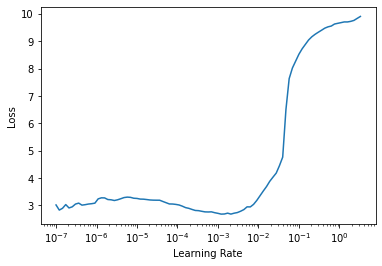

In [17]:
learn.lr_find(suggestions=True)

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [18]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(3,
 tensor(2.7576, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 123, 50264]))

In [19]:
learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,1.329834,1.362148,0.403405,0.186878,0.278367,15:09


And now we can look at the "greedy decoded" predictions ...

In [20]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"(CNN) -- A magnitude 8.0 earthquake struck the Pacific near American Samoa, triggering towering tsunami waves that gushed over the island and leaving at least 22 people dead. The tsunami wave hit right in the middle of the harbor of Pago Pago, the capital. American Samoa Gov. Togiola Tulafono, speaking from Hawaii, said Tuesday's quake ranked ""right up there with some of the worst"" disasters on the island. He said about 50 people had been treated for injuries so far but he expected that number to rise. The quake hit the small cluster of South Pacific islands early Tuesday morning. By evening, Laumoli, standing outside the LBJ Tropical Medican Center morgue in the capital of Pago Pago, confirmed 22 deaths. ""I thought it was the end of the world,"" said Dr. Salamo Laumoli, director of health services. ""I have never felt an earthquake like that before."" Laumoli feared more fatalities would turn up as rescue workers were still trying to access parts of the island severed by damaged infrastructure. Laumoli said people in outlying villages on one end of the main island have been cut off because the main bridge was washed away. ""Two or three villages have been badly damaged,"" he told CNN International. Listen to Laumoli speak about the impact of the quake and tsunami ». Tulafono cited extensive damage to roads, buildings and homes, and said he had spoken to the military about mobilizing reserve forces for assistance. The Pacific Tsunami Warning Center in Ewa Beach, Hawaii, canceled tsunami watches and warnings for American Samoa about four hours after the earthquake hit. However, a tsunami advisory is still in effect for for the coastal areas of California and Oregon. Watch report on end of tsunami warning ». The Japan Meteorological Agency also activated a tsunami advisory along its eastern coast. The precautionary alert means that the height of a possible tsunami wave would be less than a foot and a half. President Barack Obama ""declared a major disaster exists in the Territory of American Samoa"" late Tuesday and ordered federal aid to supplement local efforts. The declaration makes federal funding available to affected individuals. The tsunami waves hit right in the middle of the Pago Pago harbor, the capital, said Cinta Brown, an American Samoa homeland security official working at the island's emergency operations center. The water devastated the village of Leone. Watch a resident talk about what happened ». ""The wave came onshore and washed out people's","NEW: White House declares major disaster; orders federal aid.\nU.S. sending plane with aid, officials to help American Samoa.\nMagnitude-8.0 quake strikes near Samoan Islands early Tuesday.\nQuake struck at depth of 7.4 miles, triggered three 5-foot tsunamis.","NEW: President Obama declares major disaster in American Samoa, orders federal aid .\nTsunami warning canceled for Hawaii, but still in effect for parts of California and Oregon .\n""I thought it was the end of the world,"" American Samoa health official says of Tuesday's quake .\nGov. Togiola Tulafono says quake ranked ""right up there with some of the worst"" disasters on island .\nHe says about 50 people treated for injuries so far but he expects that number to rise ."
1,"By. Daily Mail Reporter. Two men convicted of plotting to murder and rob singer Joss Stone appealed their sentences at London's Court of Appeal today. Two men convicted of plotting to rob and kill international pop star Joss Stone appealed against their sentences today. Three judges at the Court of Appeal in London heard challenges by Kevin Liverpool and Junior Bradshaw, who were found guilty of conspiracy to murder and conspiracy to rob following a three-week trial at Exeter Crown Court last year. Liverpool was given a life sentence, with a minimum term of 10 years and eight months - the least he must serve before becoming eligible to apply for parole - while Bradshaw was jailed for 18 years. Judge Francis Gilbe

Even better though, blurr augments the fastai Learner with a `blurr_summarize` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [21]:
test_article = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
"""

In [22]:
outputs = learn.blurr_summarize(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Number of people killed if airline crashes reached 1,158 even before Air Asia plane vanished this week .
Two incidents involving Malaysia Airlines planes led to the deaths of 537 people in the past 12 months .
The remaining 456 fatalities were largely in incidents involving small commercial planes .
Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world .
All-time deadliest year for aviation was 1972 when 2,429 people were killed in 55 plane crashes .

=== Prediction 2 ===
 Number of people killed if airline crashes reached 1,158 even before Air Asia plane vanished this week .
Two incidents involving Malaysia Airlines planes led to the deaths of 537 people in the past 12 months .
The remaining 456 fatalities were largely in incidents involving small commercial planes .
Despite 2014 having the high

What about inference?  Easy!

In [23]:
learn.export(fname='ft_cnndm_export.pkl')

In [24]:
inf_learn = load_learner(fname='ft_cnndm_export.pkl')
inf_learn.blurr_summarize(test_article)

[' Number of people killed if airline crashes reached 1,158 even before Air Asia plane vanished this week .\nTwo incidents involving Malaysia Airlines planes led to the deaths of 537 people in the past 12 months .\nThe remaining 456 fatalities were largely in incidents involving small commercial planes .\nDespite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world .\nAll-time deadliest year for aviation was 1972 when 2,429 people were killed in 55 plane crashes .']

## That's it

[blurr](https://ohmeow.github.io/blurr/) supports a number of huggingface transformer model tasks in addition to summarization (e.g., sequence classification , token classification, and question/answering). The docs include examples for each of these tasks if you're curious to learn more.

For more information about ohmeow or to get in contact with me, head over to [ohmeow.com](ohmeow.com) for all the details.

Thanks!